In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
from transformers.models.qwen2.modeling_qwen2 import Qwen2ForCausalLM

model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

/opt/anaconda3/envs/deepseek_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparação

Seleciona um modelo que já utiliza tokens de pensamento

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [5]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Some parameters are on the meta device because they were offloaded to the disk.


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

Testa o modelo com um problema simples

In [ ]:
messages = [
    {"role": "user", "content": "What is 15 multiplied by 7?"}
]
prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
inputs = tokenizer(prompt, return_tensors="pt")
decoded_tokens = tokenizer.decode(inputs.input_ids[0])
print("\nTokenized prompt:")
print(decoded_tokens)


Tokenized prompt:
<｜begin▁of▁sentence｜><｜begin▁of▁sentence｜><｜User｜>What is 15 multiplied by 7?<｜Assistant｜><think>



In [5]:
# Generate the response
outputs = model.generate(
    inputs.input_ids.to(model.device),
    max_length=1000,
    temperature=0.6,
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id,
    return_dict_in_generate=True,
    output_hidden_states=True,
)

# Decode the generated tokens
decoded_output = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
print(decoded_output)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


<｜User｜>What is 15 multiplied by 7?<｜Assistant｜><think>
First, I need to calculate 15 multiplied by 7.

To do this, I can break down the multiplication into simpler parts. I'll start by multiplying 10 by 7, which gives me 70.

Next, I'll multiply 5 by 7, resulting in 35.

Finally, I'll add the two results together: 70 plus 35 equals 105.

Therefore, 15 multiplied by 7 equals 105.
</think>

**Solution:**

To find the product of 15 and 7, follow these simple steps:

1. **Multiply 10 by 7:**
   
   \[
   10 \times 7 = 70
   \]

2. **Multiply 5 by 7:**
   
   \[
   5 \times 7 = 35
   \]

3. **Add the two results together:**
   
   \[
   70 + 35 = 105
   \]

Therefore, 

\[
15 \times 7 = \boxed{105}
\]


## Testes com o espaço de representação do modelo

Testes decodificando embeddings sem passar pelo corpo do modelo.

In [58]:
def print_top_next_tokens(logits, top_k=5, bottom_k=5):
    # Calculate probabilities over full vocabulary
    probs = torch.softmax(logits[0][-1], dim=-1)
    
    # Get the top 10 most likely tokens and bottom 5 least likely tokens
    top_probs, top_indices = probs.topk(k=top_k)
    bottom_probs, bottom_indices = probs.topk(k=bottom_k, largest=False)
    
    top_logits = logits[0][-1][top_indices]
    bottom_logits = logits[0][-1][bottom_indices]

    # Decode back to text
    top_tokens = [tokenizer.decode(idx) for idx in top_indices]
    bottom_tokens = [tokenizer.decode(idx) for idx in bottom_indices]

    print(f"Top {top_k} most likely tokens when decoding embedding):")
    for i, (token, prob, logit) in enumerate(zip(top_tokens, top_probs, top_logits), 1):
        print(f"{i}. {token} (prob: {prob.item():.3f}, logit: {logit.item():.3f})")
        
    print(f"\nBottom {bottom_k} least likely tokens:")
    for i, (token, prob, logit) in enumerate(zip(bottom_tokens, bottom_probs, bottom_logits), 1):
        print(f"{i}. {token} (prob: {prob.item():.3f}, logit: {logit.item():.3f})")

Aritmética no espaço de embeddings

In [59]:
# Get the token ID
e1 = model.get_input_embeddings().weight[tokenizer.encode("king", add_special_tokens=False)[0]]
e2 = model.get_input_embeddings().weight[tokenizer.encode("man", add_special_tokens=False)[0]]
e3 = model.get_input_embeddings().weight[tokenizer.encode("woman", add_special_tokens=False)[0]]
logits = model.lm_head(((e1 - e2) + e3).reshape(1, 1, -1))  # deveria ser "queen"?
print_top_next_tokens(logits)

Top 5 most likely tokens when decoding embedding):
1. king (prob: 0.000, logit: 2.207)
2. woman (prob: 0.000, logit: 1.554)
3. ,…

 (prob: 0.000, logit: 1.253)
4. .${ (prob: 0.000, logit: 1.254)
5. ?): (prob: 0.000, logit: 1.253)

Bottom 5 least likely tokens:
1.   (prob: 0.000, logit: -1.043)
2. man (prob: 0.000, logit: -0.969)
3. , (prob: 0.000, logit: -0.977)
4.  ( (prob: 0.000, logit: -0.924)
5. - (prob: 0.000, logit: -0.817)


Embeddings da última camada correspondem aos embeddings da primeira camada?

In [60]:
# Get the token ID
embedding = model.get_input_embeddings().weight[tokenizer.encode("king", add_special_tokens=False)[0]]
logits = model.lm_head(embedding.reshape(1, 1, -1))
print_top_next_tokens(logits)

Top 5 most likely tokens when decoding embedding):
1. king (prob: 0.000, logit: 1.930)
2. King (prob: 0.000, logit: 0.729)
3.  king (prob: 0.000, logit: 0.686)
4. kers (prob: 0.000, logit: 0.679)
5. bidden (prob: 0.000, logit: 0.617)

Bottom 5 least likely tokens:
1. , (prob: 0.000, logit: -0.453)
2.   (prob: 0.000, logit: -0.456)
3.  ( (prob: 0.000, logit: -0.432)
4. - (prob: 0.000, logit: -0.357)
5. . (prob: 0.000, logit: -0.345)


In [61]:
# Get the token ID
embedding = model.get_input_embeddings().weight[tokenizer.encode("</think>", add_special_tokens=False)[0]]
logits = model.lm_head(embedding.reshape(1, 1, -1))
print_top_next_tokens(logits)

Top 5 most likely tokens when decoding embedding):
1. ".. (prob: 0.000, logit: 0.864)
2. ,…

 (prob: 0.000, logit: 0.830)
3. )?. (prob: 0.000, logit: 0.832)
4. ?): (prob: 0.000, logit: 0.830)
5. ?,
 (prob: 0.000, logit: 0.819)

Bottom 5 least likely tokens:
1.   (prob: 0.000, logit: -0.786)
2.  ( (prob: 0.000, logit: -0.692)
3. , (prob: 0.000, logit: -0.700)
4. . (prob: 0.000, logit: -0.585)
5. - (prob: 0.000, logit: -0.552)


Pega os logits do token `</think>` na última camada

In [72]:
text = """<｜User｜>What is 15 multiplied by 7?<｜Assistant｜><think>
To solve 15 multiplied by 7, I can start by multiplying 10 by 7, which equals 70. Then, I'll multiply 5 by 7, resulting in 35. Adding these two products together, 70 plus 35, gives me the final answer of 105.
"""

# Tokenize input text
inputs = tokenizer(text, return_tensors="pt").to(model.device)

# Get model outputs
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

# Get logits from output
logits1 = outputs.logits
hidden_state = outputs.hidden_states[-1]
print_top_next_tokens(logits1)

Top 5 most likely tokens when decoding embedding):
1. </think> (prob: 1.000, logit: 25.750)
2. </ (prob: 0.000, logit: 15.953)
3. Alternatively (prob: 0.000, logit: 13.242)
4.   
 (prob: 0.000, logit: 12.602)
5. ####
 (prob: 0.000, logit: 12.523)

Bottom 5 least likely tokens:
1. " (prob: 0.000, logit: 4.086)
2. ! (prob: 0.000, logit: 1.679)
3. # (prob: 0.000, logit: 7.598)
4. % (prob: 0.000, logit: 3.184)
5. $ (prob: 0.000, logit: 2.434)


In [66]:
# Calculate cosine similarity between logits and logits1
cos_sim = torch.nn.functional.cosine_similarity(logits[0][-1].view(1,-1), logits1[0][-1].view(1,-1))
print(f"Cosine similarity between logits: {cos_sim.item():.4f}")

Cosine similarity between logits: 0.0848


In [76]:
# Calculate cosine similarity between embeddings and the hidden state
cos_sim = torch.nn.functional.cosine_similarity(embedding.view(1,-1), hidden_state[0][-1].view(1,-1))
print(f"Cosine similarity between embeddings: {cos_sim.item():.4f}")

Cosine similarity between embeddings: 0.0773


## Função `generate` modificada

Generate padrão (baseline)

In [3]:
def generate_text(model, tokenizer, prompt, max_length=500, temperature=0.6):
    # Encode the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    
    # Get initial embeddings
    with torch.no_grad():
        inputs_embeds = model.model.embed_tokens(input_ids)
        
    # Keep track of generated tokens for decoding
    generated_ids = input_ids.clone()
    
    # Generate tokens auto-regressively
    for _ in range(max_length):
        # Get model outputs using accumulated embeddings
        with torch.no_grad():
            outputs = model.model(inputs_embeds=inputs_embeds)
            logits = model.lm_head(outputs[0])
            
        # Get logits for next token prediction
        next_token_logits = logits[:, -1, :]
        
        # Apply temperature scaling
        next_token_logits = next_token_logits / temperature
        
        # Get probabilities
        probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
        
        # Sample next token
        next_token = torch.multinomial(probs, num_samples=1)
        
        # Print the generated token
        print(tokenizer.decode(next_token[0]), end='', flush=True)
        
        # Get embedding for next token
        with torch.no_grad():
            next_embed = model.model.embed_tokens(next_token)
            
        # Concatenate next embed
        inputs_embeds = torch.cat([inputs_embeds, next_embed], dim=1)
        
        # Update generated ids for final decoding
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
        
        # Check if EOS token is generated
        if next_token[0].item() == tokenizer.eos_token_id:
            break
    
    # Decode the generated tokens
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text

# Test the generation
prompt = tokenizer.apply_chat_template(
    [{"role": "user", "content": "What is 15 multiplied by 7?"}],
    add_generation_prompt=True,
    tokenize=False
)
print(f"\nPrompt: {prompt}")
generated = generate_text(model, tokenizer, prompt, temperature=0.6)


Prompt: <｜begin▁of▁sentence｜><｜User｜>What is 15 multiplied by 7?<｜Assistant｜><think>

To solve 15 multiplied by 7, I start by breaking down the number 15 into 10 and 5. Multiplying 10 by 7 gives me 70, and multiplying 5 by 7 results in 35. Finally, adding these two products together, 70 and 35, gives the final result of 105.
</think>

To find the product of 15 multiplied by 7, follow these simple steps:

### Step 1: Break Down the Numbers
Break down 15 into its tens and ones place:
- 15 = 10 + 5

### Step 2: Multiply Each Part by 7
- Multiply the tens place: \( 10 \times 7 = 70 \)
- Multiply the ones place: \( 5 \times 7 = 35 \)

### Step 3: Add the Results Together
- Add the two products: \( 70 + 35 = 105 \)

### Final Answer
\[
\boxed{105}
\]<｜end▁of▁sentence｜>

Generate utilizando o espaço latente dentro dos tokens `<think/>`


In [12]:
def generate_text_latent(model, tokenizer, prompt, max_length=1000, max_thinking_tokens=100):
    # Encode the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    
    # Track latent state
    # Scan input ids for think tags
    thinking_tokens = max_thinking_tokens
    think_start = tokenizer.encode("<think>", add_special_tokens=False)[0]
    think_end = tokenizer.encode("</think>", add_special_tokens=False)[0]
    think_count = 0
    for token_id in input_ids[0]:
        if token_id == think_start:
            think_count += 1
        elif token_id == think_end:
            think_count -= 1
    latent = think_count > 0  # True if there's an unclosed think tag
    if latent:
        print(input_ids.shape)
        print(torch.tensor([[think_start]]).shape)
        input_ids = torch.cat([input_ids, torch.tensor([[think_start]]).to(model.device)], dim=1)
        print("<latent>", end='', flush=True)
    else:
        input_ids = torch.cat([input_ids, torch.tensor([[think_end]]).to(model.device)], dim=1)
        print("</latent>", end='', flush=True)

    # Keep track of generated tokens for decoding
    generated_ids = input_ids.clone()

    # Get initial embeddings
    with torch.no_grad():
        inputs_embeds = model.model.embed_tokens(input_ids)

    # Generate tokens auto-regressively
    for _ in range(max_length):
        # Get model outputs using accumulated embeddings
        with torch.no_grad():
            outputs = model.model(inputs_embeds=inputs_embeds)
            logits = model.lm_head(outputs[0])
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)

        # Update latent state based on token
        if latent:
            thinking_tokens -= 1
            if next_token[0].item() != think_end and thinking_tokens > 0:
                # Still thinking
                next_token_hidden = outputs[0][:, -1, :]
                next_embed = next_token_hidden.unsqueeze(1)
                # inputs_embeds = inputs_embeds[:, :-1, :]  # Uncomment this to replace the last token instead of appending it to the sequence
            else:
                # Exit latent space
                latent = False
                next_token = tokenizer("\n</latent>\n", add_special_tokens=False, return_tensors="pt").input_ids.to(model.device)
                next_embed = model.model.embed_tokens(next_token)
                print("</latent>", end='', flush=True)
                thinking_tokens = max_thinking_tokens
        else:
            if next_token[0] == think_start:
                # Start thinking
                latent = True
                print("<latent>", end='', flush=True)
            with torch.no_grad():
                next_embed = model.model.embed_tokens(next_token)

        # Concatenate next embed
        inputs_embeds = torch.cat([inputs_embeds, next_embed], dim=1)
        # Update generated ids for final decoding
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
        
        # Print the generated token
        print(tokenizer.decode(next_token[0]), end='', flush=True)

        # Check if EOS token is generated
        if tokenizer.eos_token_id in next_token[0]:
            break

    # Decode the generated tokens
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return generated_text

# Test the generation
prompt = tokenizer.apply_chat_template(
    [{"role": "user", "content": "What is 15 multiplied by 7?"}],
    add_generation_prompt=True,
    tokenize=False
)
print(prompt, end='', flush=True)
generated = generate_text_latent(model, tokenizer, prompt, max_thinking_tokens=100)

<｜begin▁of▁sentence｜><｜User｜>What is 15 multiplied by 7?<｜Assistant｜><think>
torch.Size([1, 16])
torch.Size([1, 1])
<latent>









的的的的的。。






。。。。。。。！！！！！！!!。。。。。技巧方法方法方法地解决算！了啦！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！</latent>
</latent>
嗯，今天老师布置了一个数学题，让我算一下15乘以7是多少。刚开始看到这个题目的时候，我觉得挺简单的，但还是有点紧张，怕自己算错了。不过没关系，我慢慢来，仔细想一想。

首先，我得回忆一下乘法的基本知识。乘法就是求几个相同数相加的总和，对吧？比如说，15乘以7，就是15加上自己6次，也就是15+15+15+15+15+15+15。嗯，这样算的话，我得算出这个总和是多少。

不过，这样算起来可能有点麻烦，而且容易出错。我想，有没有什么简便的方法呢？比如说，分解因数或者找规律。比如说，15乘以7，我可以把15拆成10加5，然后分别乘以7，再把结果加起来。这样是不是更简单呢？

好，我来试试看。首先，10乘以7等于70，然后5乘以7等于35。接下来，我把这两个结果加起来，70加35等于105。所以，15乘以7的结果应该是105。

不过，我还是有点担心自己是不是哪里算错了。为了确认一下，我可以换一种方法来验证一下。比如说，我可以使用竖式乘法来计算。先把15写下来，然后乘以7，从个位开始乘起。

首先，5乘以7等于35，写下5，进位3。然后，1乘以7等于7，加上进位的3，等于10。所以，结果就是105。嗯，和之前的结果一致，看来是对的。

或者，我可以使用分配律来计算。比如说，15乘以7等于（10+5）乘以7，也就是10乘以7加上5乘以7，结果也是70加35等于105。这样看来，不管用什么方法，结果都是105，所以应该是正确的。

不过，我还是有点好奇，有没有其他的方法可以用来验证这个结果。比如说，我可以使用计算器来计算，或者用其他数学技巧来确认。不过，现在手头没有计算器，只能依靠自己的计算能力了。

再想想，15乘以7其实可以看作是15乘以7等于105，对吗？因为15乘以7等于10

Mapas de atenção (até agora não funciona)

<｜begin▁of▁sentence｜><｜User｜>What is 15 multiplied by 7?<｜Assistant｜><think>
<latent>!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

/home/bryan/miniconda3/envs/llm/lib/python3.9/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/bryan/miniconda3/envs/llm/lib/python3.9/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


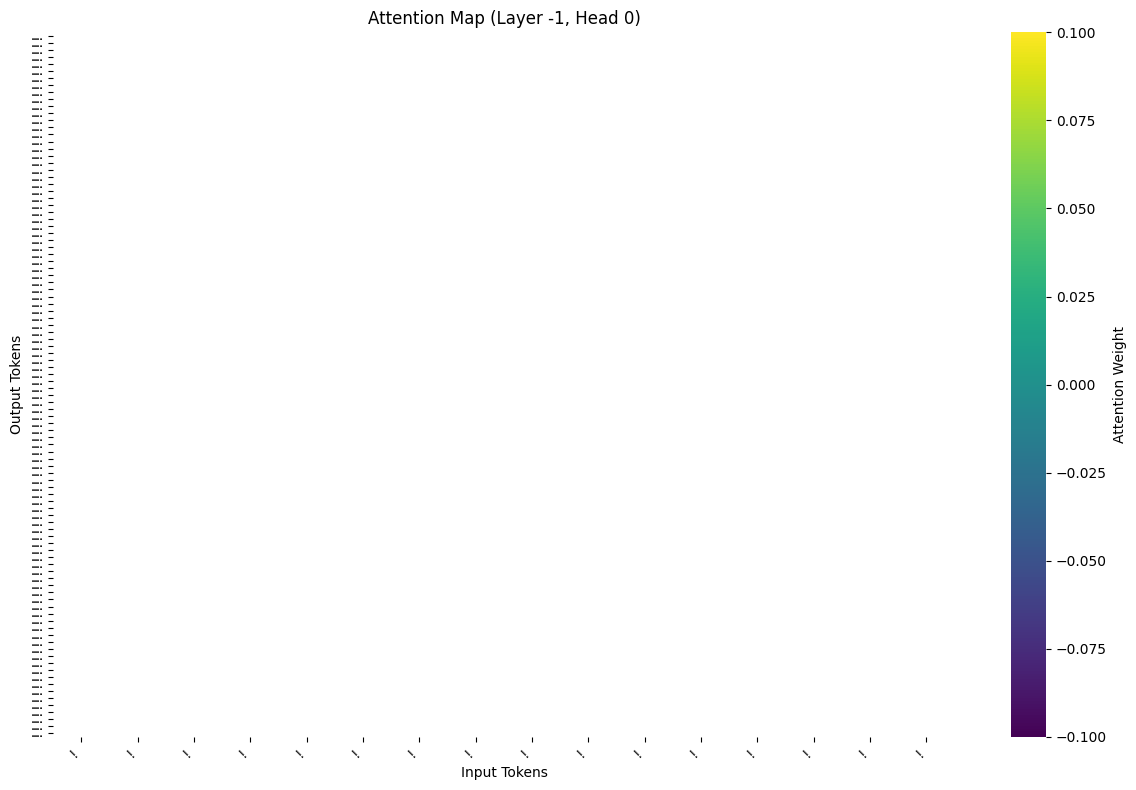

In [ ]:
def generate_text_latent_with_attention(model, tokenizer, prompt, max_length=100, max_thinking_tokens=100):
    # Encode the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    
    # Get initial embeddings
    with torch.no_grad():
        inputs_embeds = model.model.embed_tokens(input_ids)
        
    # Keep track of generated tokens for decoding
    generated_ids = input_ids.clone()
    
    # Track latent state
    # Scan input ids for think tags
    think_start = tokenizer.encode("<think>", add_special_tokens=False)[0]
    think_end = tokenizer.encode("</think>", add_special_tokens=False)[0]
    think_count = 0
    for token_id in input_ids[0]:
        if token_id == think_start:
            think_count += 1
        elif token_id == think_end:
            think_count -= 1
    latent = think_count > 0  # True if there's an unclosed think tag
    print("<latent>" if latent else "</latent>", end='', flush=True)

    thinking_tokens = max_thinking_tokens
    all_attention_weights = []
    all_tokens = []

    # Generate tokens auto-regressively
    for _ in range(max_length):
        # Get model outputs using accumulated embeddings
        with torch.no_grad():
            outputs = model.model(inputs_embeds=inputs_embeds, output_attentions=True)  # modelo para de funcionar quando usa output_attentions
            logits = model.lm_head(outputs[0])
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)

        # Store attention weights from last layer
        attention_weights = outputs.attentions[-1]  # Shape: [batch, num_heads, seq_len, seq_len]
        all_attention_weights.append(attention_weights)

        # Update latent state based on token
        if latent:
            thinking_tokens -= 1
            if next_token[0].item() != think_end and thinking_tokens > 0:
                next_token_hidden = outputs[0][:, -1, :]
                next_embed = next_token_hidden.unsqueeze(1)
            else:
                latent = False
                next_token = tokenizer("\n</think>\n", add_special_tokens=False, return_tensors="pt").input_ids.to(model.device)
                next_embed = model.model.embed_tokens(next_token)
                print("</latent>", end='', flush=True)
                thinking_tokens = max_thinking_tokens
        else:
            if next_token[0] == think_start:
                latent = True
                print("<latent>", end='', flush=True)
            with torch.no_grad():
                next_embed = model.model.embed_tokens(next_token)

        # Concatenate next embed
        inputs_embeds = torch.cat([inputs_embeds, next_embed], dim=1)
        # Update generated ids for final decoding
        generated_ids = torch.cat([generated_ids, next_token], dim=1)
        
        # Print the generated token
        print(tokenizer.decode(next_token[0]), end='', flush=True)

        # Store generated token
        all_tokens.append(tokenizer.decode(next_token[0]))

        # Check if EOS token is generated
        if tokenizer.eos_token_id in next_token[0]:
            break
        
        
    # Decode the generated tokens
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    return generated_text, all_attention_weights, all_tokens

def plot_attention_map(attention_weights, tokens, layer_idx=-1, head_idx=0):
    """
    Plot attention map for a specific layer and attention head
    
    Args:
        attention_weights: List of attention tensors
        tokens: List of token strings
        layer_idx: Which transformer layer to visualize (-1 for last layer)
        head_idx: Which attention head to visualize
    """
    # Convert attention weights to numpy array
    # Get sequence length for each attention matrix
    seq_lens = [w.size(-1) for w in attention_weights]
    min_seq_len = min(seq_lens)
    
    # Truncate each attention matrix to minimum sequence length
    attn_matrix = torch.cat([w[0, head_idx, -1:, :min_seq_len] for w in attention_weights], dim=0)
    attn_matrix = attn_matrix.cpu().numpy()
    
    # Create figure
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        attn_matrix,
        xticklabels=tokens[:min_seq_len],
        yticklabels=tokens[-len(attn_matrix):],
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'}
    )
    
    plt.title(f'Attention Map (Layer {layer_idx}, Head {head_idx})')
    plt.xlabel('Input Tokens')
    plt.ylabel('Output Tokens')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Test the generation
prompt = tokenizer.apply_chat_template(
    [{"role": "user", "content": "What is 15 multiplied by 7?"}],
    add_generation_prompt=True,
    tokenize=False
) # + "Chinese Dangerous wishes</think>"
print(prompt, end='', flush=True)
generated, attention_weights, tokens = generate_text_latent_with_attention(
    model, tokenizer, prompt, max_thinking_tokens=10
)

# Plot attention map for the last layer, first head
plot_attention_map(attention_weights, tokens)

## Custom Model

In [5]:
del model

In [5]:
from models.custom_qwen.latent_modeling import LatentModelForCausalLM

model = LatentModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_tokens("<latent>")
tokenizer.add_tokens("</latent>")

model.config.start_think_token_id = tokenizer.convert_tokens_to_ids("<think>")
model.config.end_think_token_id = tokenizer.convert_tokens_to_ids("</think>")
model.config.start_latent_token_id = tokenizer.convert_tokens_to_ids("<latent>")
model.config.end_latent_token_id = tokenizer.convert_tokens_to_ids("</latent>")
model.config.auto_map = {
    "AutoModelForCausalLM": "latent_modeling.LatentModelForCausalLM",
    "AutoModel": "latent_modeling.LatentModelForCausalLM"
}
model.config.head_dim = model.config.hidden_size // model.config.num_attention_heads
model.resize_token_embeddings(len(tokenizer))

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Embedding(151667, 1536)

In [6]:
output_dir = "custom_qwen"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('custom_qwen/tokenizer_config.json',
 'custom_qwen/special_tokens_map.json',
 'custom_qwen/tokenizer.json')

In [6]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    "custom_qwen",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "custom_qwen",
    trust_remote_code=True
)
model

LatentModelForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151667, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_em

In [8]:
# Get the signature of the generate method
import inspect

generate_signature = inspect.signature(model.generate)
print("Available arguments for model.generate:")
for param_name, param in generate_signature.parameters.items():
    print(f"{param_name}: {param.default}")

Available arguments for model.generate:
input_ids: None
attention_mask: None
max_length: 50
num_return_sequences: 1
temperature: 1.0
top_k: 50
top_p: 1.0
repetition_penalty: 1.0
max_thinking_tokens: 10
kwargs: <class 'inspect._empty'>


In [9]:
input_text = tokenizer.apply_chat_template(
    [{"role": "user", "content": "What is 15 multiplied by 7?"}],
    add_generation_prompt=True,
    tokenize=False
)
input_ids = tokenizer.encode(input_text, return_tensors="pt")

generated_ids = model.generate(input_ids=input_ids.to(model.device))
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print(generated_text)

<｜User｜>What is 15 multiplied by 7?<｜Assistant｜><think>
To100000</think>  here? No. Wait, number of birds per Moon. For more information, visit. How many Birds per Year? No. 551. I have a question.

Alright, so I have


In [ ]:
# MODEL=deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
MODEL="../custom_qwen"
MODEL_ARGS="pretrained=$MODEL,dtype=bfloat16,max_model_length=32768,gpu_memory_utilisation=0.9"
OUTPUT_DIR=data/evals/$MODEL

# MATH-500
TASK=math_500
lighteval vllm $MODEL_ARGS "custom|$TASK|0|0" \
    --custom-tasks src/open_r1/evaluate.py \
    --use-chat-template \
    --output-dir $OUTPUT_DIR

In [1]:
from openai import OpenAI

# Create client pointing to local server
client = OpenAI(
    base_url="http://localhost:18080/v1",
    api_key="not-needed" # The API key is not actually used but required
)

# Test with a simple completion
response = client.chat.completions.create(
    model="custom_qwen",
    messages=[
        {"role": "user", "content": "Hello world"}
    ]
)

print(response.choices[0].message.content) 

Alright, the user greeted me with "Hello world." It sounds like they're just starting a conversation.

I should respond in a friendly and open manner to set a positive tone.

Maybe I can offer to help out with whatever they need.

Keeping it simple and welcoming is probably the best approach.
</think>

Hello! It's great to have you here. How can I assist you today?
